# EOmaps Workshop GeoPython 2024
<font size=3>Interactive geo-data analysis with EOmaps and the scientific python infrastructure.</font>

## 03 - Spatio-temporal analysis

In [12]:
from pathlib import Path
from functools import lru_cache

import pandas as pd
import xarray as xar
from matplotlib.dates import ConciseDateFormatter

from eomaps import Maps, widgets

In [ ]:
%matplotlib qt
Maps.config(always_on_top=True)      # keep figures "always on top"

In [2]:
# a list of all files
files = list(Path("data").iterdir())

In [3]:
ncfile = xar.open_dataset(files[0])
ncfile

<xarray.Dataset> Size: 441MB
Dimensions:    (lat: 1800, lon: 3600, time: 1)
Coordinates:
  * lat        (lat) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon        (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 8B 2023-06-01T12:00:00
Data variables: (12/18)
    crs        |S1 1B ...
    SWI_005    (time, lat, lon) float32 26MB ...
    SWI_010    (time, lat, lon) float32 26MB ...
    SWI_001    (time, lat, lon) float32 26MB ...
    SWI_015    (time, lat, lon) float32 26MB ...
    SWI_100    (time, lat, lon) float32 26MB ...
    ...         ...
    QFLAG_100  (time, lat, lon) float32 26MB ...
    QFLAG_020  (time, lat, lon) float32 26MB ...
    QFLAG_005  (time, lat, lon) float32 26MB ...
    QFLAG_001  (time, lat, lon) float32 26MB ...
    QFLAG_060  (time, lat, lon) float32 26MB ...
    SSF        (time, lat, lon) float32 26MB ...
Attributes: (12/25)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2023
    geospatial_lat_max:   89.95
    geospatial_lat_min:   -89.95
    geospatial_lon_max:   179.95
    ...                   ...
    region_name:          GLOBE
    sensor:               ASCAT
    source:               Derived from EO microwave scatterometer observations
    time_coverage_end:    2023-06-01T12:00:00Z
    time_coverage_start:  2023-05-31T12:00:00Z
    title:                Daily Soil Water Index 0.1degree: GLOBE 2023-06-01T...

In [4]:
@lru_cache
def get_ts(lon, lat, parameter):
    dats = []
    for filepath in files:
        with xar.open_dataset(filepath) as ncfile:
            dats.append(ncfile.sel(lon=lon, lat=lat, method="nearest", drop=True)[parameter].to_dataframe())
    dats = pd.concat(dats)
    return dats

In [5]:
df = get_ts(45.5, 45.5, "SWI_010")
df.head()

,SWI_010
time,
2023-06-01 12:00:00,43.5
2023-06-01 12:00:00,43.5
2023-06-02 12:00:00,44.0
2023-06-03 12:00:00,45.0
2023-06-04 12:00:00,46.0


In [6]:
m = Maps(layer="all")
m.set_extent((-0.6416666666666515, 30.15833333333336, 32.25, 50.85833333333335))

In [7]:
ax = m.f.add_subplot()
ax.xaxis.set_major_formatter(ConciseDateFormatter(ax.xaxis.get_major_locator()))

layout = {
    "figsize": [6.4, 4.8],
    "0_map": [0.10129, 0.35, 0.78621, 0.63333],
    "1_": [0.075, 0.08333, 0.8625, 0.25],
}
m.apply_layout(layout)

In [8]:
# a custom callback to print timeseries on click
def print_ts(pos, val, m, parameter, time, **kwargs):
    df = get_ts(*pos, parameter=parameter)
    a, = ax.plot(df, c="k")
    marker, = ax.plot(time, val, marker="o", c="r")
    
    m.cb.pick.add_temporary_artist(a)
    m.cb.pick.add_temporary_artist(marker)
    m.redraw()

In [9]:
# a function that will be executed if the layer becomes visible
def on_layer(m, filepath, parameter):
    with xar.open_dataset(filepath) as ncfile:
        data = ncfile.isel(time=0)[parameter]
        m.set_data(data, "lon", "lat", parameter=parameter, crs=ncfile.crs.spatial_ref)
        m.set_shape.shade_raster()
        m.plot_map(set_extent=False, cmap="viridis")
        
        m.cb.pick.set_execute_on_all_layers(True)
        m.cb.pick.attach.annotate()
        m.cb.pick.attach(print_ts, m=m, parameter=parameter, time=ncfile.time)

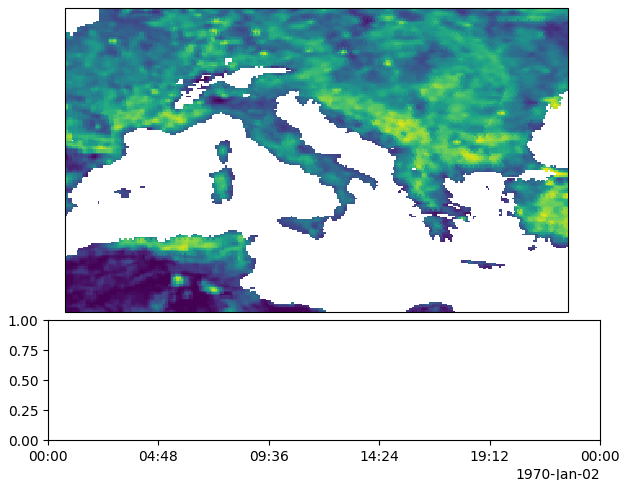

In [10]:
for filepath in files:
    m.on_layer_activation(on_layer, layer=filepath.stem, filepath=filepath, parameter="SWI_001")

m.show_layer(files[0].stem)
m.show()

In [11]:
display(widgets.LayerSelectionSlider(m, layers=[i.stem for i in files], layout=dict(width='500px')))
m.fetch_layers()

LayerSelectionSlider(description='Layers', layout=Layout(width='500px'), options=(('c_gls_SWI_202306011200_GLO…